# 电影票房预测问题

## 数据特征化处理

In [1]:
import numpy as np 
import pandas as pd 
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt 
plt.rcParams["font.sans-serif"] = ["SimHei"] #解决中文字符乱码的问题
from matplotlib import cm,colors
cmap=cm.get_cmap('Blues_r',6)
color=[colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)] 

In [2]:
# 全部转化成数值类变量
mydata = pd.read_csv("../数据/cleared_data.csv")
# 电影名称长度
mydata['movie_name_len'] = mydata['movie_title'].map(len)
del mydata['movie_title']
# 语言分类
index_language = mydata['language'].isin(['Dzongkha','Russian','Arabic','Hebrew','Vietnamese','Indonesian','Zulu','Bosnian','Czech',
                                          'Icelandic','Hungarian','Mongolian','Aramaic','Telugu','Kazakh','Maya','Filipino','Swedish'])
mydata.loc[index_language,'language'] = 'Others'
tmp = pd.get_dummies(mydata['language'], prefix='language')
del mydata['language']
mydata = pd.concat([mydata, tmp], axis=1)
# 国家分类
index_country = mydata['country'].isin(['Colombia','Poland','Indonesia','Afghanistan','Israel','Chile','Georgia','West Germany',
                                        'Official site','Taiwan','Greece','Belgium','Romania','Aruba','Peru','New Line','Sweden'])
mydata.loc[index_country,'country'] = 'Others'
tmp = pd.get_dummies(mydata['country'], prefix='country')
del mydata['country']
mydata = pd.concat([mydata, tmp], axis=1)
# 等级分类
tmp = pd.get_dummies(mydata['content_rating'], prefix='content_rating')
del mydata['content_rating']
mydata = pd.concat([mydata, tmp], axis=1)
# 年月
mydata['year'] = mydata['title_year'].apply(lambda x: x[:4]).astype('int')  #添加年列和月列
mydata['month'] = mydata['title_year'].apply(lambda x: x[5:]).astype('int')
del mydata['title_year']
# 色彩分类
tmp = pd.get_dummies(mydata['color'], prefix='color')
del mydata['color']
mydata = pd.concat([mydata, tmp], axis=1)
# 类型数
mydata['genre_count'] = [i.count('|')+1 for i in mydata['genres']]
# 电影风格拆分并计算平均票房
genre_data = pd.read_csv("../数据/genre_data.csv")
all_genres = set(genre_data['genre'])
mydata['genre_list'] = [i.split('|') for i in mydata['genres']]
generes_mean_income = {}
generes_mean_budget = {}
for genre in all_genres:
    mydata['has_cur_genre'] = mydata['genre_list'].map(lambda x: genre in x)
    tmp = mydata[mydata['has_cur_genre'] == True]
    generes_mean_income[genre] = np.mean(tmp['gross'])
    generes_mean_budget[genre] = np.mean(tmp['budget'])
    del mydata['has_cur_genre']
# 根据 generes 列表计算出的平均票房收入
mydata['generes_mean_income'] = mydata['genre_list'].map(lambda gs: np.mean([generes_mean_income[g] for g in gs]))
# 根据 generes 列表计算出的电影预算
mydata['generes_mean_budget'] = mydata['genre_list'].map(lambda gs: np.mean([generes_mean_budget[g] for g in gs]))
del mydata['genres']
del mydata['genre_list']
# 关键字数
mydata['keyword_count'] = [i.count('|')+1 for i in mydata['plot_keywords']]
del mydata['plot_keywords']
# 删除一些无法数值化变量
del mydata['director_name']
del mydata['actor_1_name']
del mydata['actor_2_name']
del mydata['actor_3_name']
del mydata['movie_imdb_link']

mydata.head(2)

,Unnamed: 0,duration,budget,gross,aspect_ratio,facenumber_in_poster,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,...,content_rating_PG-13,content_rating_R,year,month,color_ Black and White,color_Color,genre_count,generes_mean_income,generes_mean_budget,keyword_count
0,0,178.0,237000000.0,760505847.0,1.78,0,0.0,1000.0,936.0,855.0,...,1,0,2009,2,0,1,4,8.825287e+07,8.288073e+07,5
1,1,169.0,300000000.0,309404152.0,2.35,0,563.0,40000.0,5000.0,1000.0,...,1,0,2007,9,0,1,3,8.957078e+07,7.744564e+07,5


In [3]:
# 标签经过 log1p 转换，使其更偏向于正态分布
mydata['gross'] = np.log1p(mydata['gross'])

In [4]:
from sklearn.model_selection import train_test_split
# 拆分训练集和测试集
all_y = mydata['gross'].values
del mydata['gross']
all_x = mydata
# 划分测试集
train_all_x, test_x, train_all_y, test_y = train_test_split(all_x, all_y, test_size=0.1, random_state=66)
print('训练集：{}, 测试集: {}'.format(train_all_x.shape[0], test_x.shape[0]))
# 多折交叉验证
roof_flod = 10

训练集：3336, 测试集: 371


## 电影票房预测

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# The error metric: RMSE on the log of the incomes.
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

### 多元线性回归

In [6]:
kf = KFold(n_splits=roof_flod, shuffle=True, random_state=66)

pred_train_full_lr = np.zeros(train_all_x.shape[0])
pred_test_full_lr = 0
cv_scores = []
train_scores = []

for i, (train_index, val_index) in enumerate(kf.split(train_all_x, train_all_y)):   #全标签（训练），部分标签（验证）
    print('==> perform fold {}, train size: {}, validate size: {}'.format(i, len(train_index), len(val_index)))
    train_x, val_x = train_all_x.iloc[train_index, :], train_all_x.iloc[val_index, :]
    train_y, val_y = train_all_y[train_index], train_all_y[val_index]
    
    # 创建多元线性回归模型
    model = LinearRegression()
    model.fit(train_x, train_y)

    # predict train
    predict_train = model.predict(train_x)
    train_rmse = rmse(predict_train, train_y)
    # predict validate
    predict_valid = model.predict(val_x)
    valid_rmse = rmse(predict_valid, val_y)
    # predict test
    predict_test = model.predict(test_x)
    
    print('train_rmse = {}, valid_rmse = {}'.format(train_rmse, valid_rmse))
    train_scores.append(train_rmse)
    cv_scores.append(valid_rmse)

    # run-out-of-fold predict
    pred_train_full_lr[val_index] = predict_valid
    pred_test_full_lr += predict_test

pred_test_full_lr /= roof_flod
mean_cv_scores = np.mean(cv_scores)
print( 'Mean train RMSE:', np.mean(train_scores), ', Mean cv RMSE:', np.mean(cv_scores),', Test RMSE:', rmse(pred_test_full_lr, test_y))


==> perform fold 0, train size: 3002, validate size: 334
train_rmse = 1.3718297172559748, valid_rmse = 1.5611031255356844
==> perform fold 1, train size: 3002, validate size: 334
train_rmse = 1.371685693303599, valid_rmse = 1.5329663917312124
==> perform fold 2, train size: 3002, validate size: 334
train_rmse = 1.3933723553943067, valid_rmse = 1.4441711734154468
==> perform fold 3, train size: 3002, validate size: 334
train_rmse = 1.391293662448454, valid_rmse = 1.366945903607546
==> perform fold 4, train size: 3002, validate size: 334
train_rmse = 1.3900463140525923, valid_rmse = 1.3785296206217401
==> perform fold 5, train size: 3002, validate size: 334
train_rmse = 1.3930441009637342, valid_rmse = 1.3436812941139424
==> perform fold 6, train size: 3003, validate size: 333
train_rmse = 1.3943083684643278, valid_rmse = 1.357328215839516
==> perform fold 7, train size: 3003, validate size: 333
train_rmse = 1.3775708216991516, valid_rmse = 1.4964878404342792
==> perform fold 8, train si

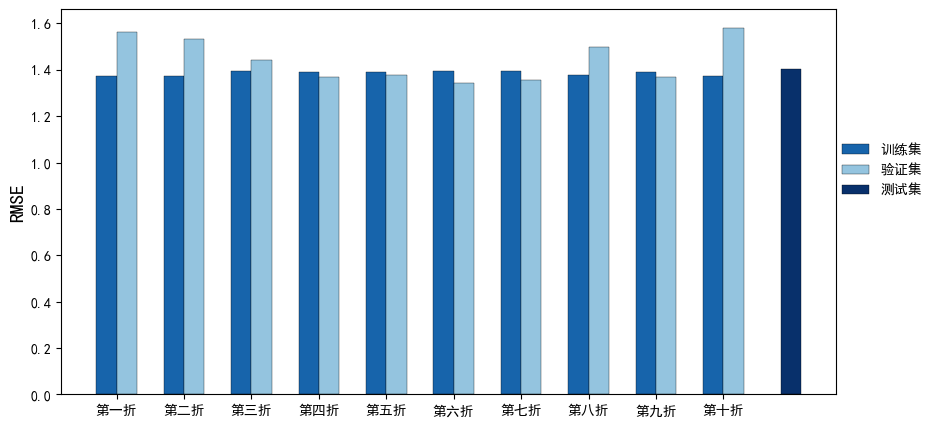

In [7]:
x = np.arange(10)
x_label = ['第一折','第二折','第三折','第四折','第五折','第六折','第七折','第八折','第九折','第十折']
y1 = np.array(train_scores)
y2 = np.array(cv_scores)
fig=plt.figure(figsize=(10, 5))
plt.bar(x-0.15, y1, width=0.3, color=color[1], label='训练集', edgecolor='k', linewidth=0.25)
plt.bar(x+0.15, y2, width=0.3, color=color[3], label='验证集', edgecolor='k', linewidth=0.25)
plt.bar(10, rmse(pred_test_full_lr, test_y), width=0.3, color=color[0], label='测试集', edgecolor='k', linewidth=0.25)
plt.xticks(x, x_label, size=10)
plt.ylabel('RMSE',fontsize=14)
plt.legend(loc=(1, 0.5), ncol=1, frameon=False)
plt.show()

### 岭回归

In [8]:
kf = KFold(n_splits=roof_flod, shuffle=True, random_state=42)

pred_train_full_ridge = np.zeros(train_all_x.shape[0])
pred_test_full_ridge = 0
cv_scores = []
train_scores = []

for i, (train_index, val_index) in enumerate(kf.split(train_all_x, train_all_y)):
    print('==> perform fold {}, train size: {}, validate size: {}'.format(i, len(train_index), len(val_index)))
    train_x, val_x = train_all_x.iloc[train_index, :], train_all_x.iloc[val_index, :]
    train_y, val_y = train_all_y[train_index], train_all_y[val_index]
    
    # 创建决策树回归模型
    model = Ridge()
    model.fit(train_x, train_y)

    # predict train
    predict_train = model.predict(train_x)
    train_rmse = rmse(predict_train, train_y)
    # predict validate
    predict_valid = model.predict(val_x)
    valid_rmse = rmse(predict_valid, val_y)
    # predict test
    predict_test = model.predict(test_x)

    print('train_rmse = {}, valid_rmse = {}'.format(train_rmse, valid_rmse))
    train_scores.append(train_rmse)
    cv_scores.append(valid_rmse)

    # run-out-of-fold predict
    pred_train_full_ridge[val_index] = predict_valid
    pred_test_full_ridge += predict_test

pred_test_full_ridge /= roof_flod
mean_cv_scores = np.mean(cv_scores)
print('Mean train RMSE:', np.mean(train_scores), ', Mean cv RMSE:', np.mean(cv_scores), ', Test RMSE:', rmse(pred_test_full_ridge, test_y))


==> perform fold 0, train size: 3002, validate size: 334
train_rmse = 1.4025097247422824, valid_rmse = 1.3101250404933147
==> perform fold 1, train size: 3002, validate size: 334
train_rmse = 1.3954424709734323, valid_rmse = 1.3854300985942383
==> perform fold 2, train size: 3002, validate size: 334
train_rmse = 1.368502320477755, valid_rmse = 1.6019715534914087
==> perform fold 3, train size: 3002, validate size: 334
train_rmse = 1.4014699400543338, valid_rmse = 1.3175967401430908
==> perform fold 4, train size: 3002, validate size: 334
train_rmse = 1.3933452650989893, valid_rmse = 1.3953506683286303
==> perform fold 5, train size: 3002, validate size: 334
train_rmse = 1.3799551582148637, valid_rmse = 1.505528820196984
==> perform fold 6, train size: 3003, validate size: 333
train_rmse = 1.3868259851525315, valid_rmse = 1.4671963138132917
==> perform fold 7, train size: 3003, validate size: 333
train_rmse = 1.3859445716406922, valid_rmse = 1.4539017195619803
==> perform fold 8, train 

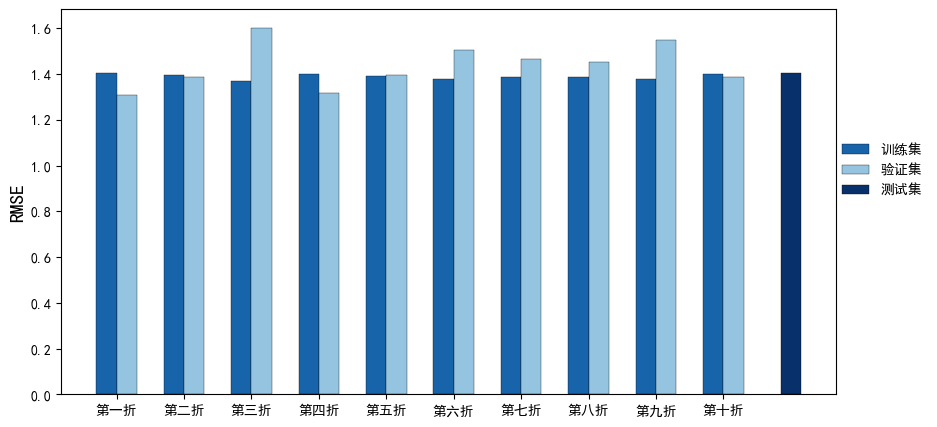

In [9]:
x = np.arange(10)
x_label = ['第一折','第二折','第三折','第四折','第五折','第六折','第七折','第八折','第九折','第十折']
y1 = np.array(train_scores)
y2 = np.array(cv_scores)
fig=plt.figure(figsize=(10, 5))
plt.bar(x-0.15, y1, width=0.3, color=color[1], label='训练集', edgecolor='k', linewidth=0.25)
plt.bar(x+0.15, y2, width=0.3, color=color[3], label='验证集', edgecolor='k', linewidth=0.25)
plt.bar(10, rmse(pred_test_full_lr, test_y), width=0.3, color=color[0], label='测试集', edgecolor='k', linewidth=0.25)
plt.xticks(x, x_label, size=10)
plt.ylabel('RMSE',fontsize=14)
plt.legend(loc=(1, 0.5), ncol=1, frameon=False)
plt.show()

### lasso回归

In [10]:
kf = KFold(n_splits=roof_flod, shuffle=True, random_state=42)

pred_train_full_lasso = np.zeros(train_all_x.shape[0])
pred_test_full_lasso = 0
cv_scores = []
train_scores = []

for i, (train_index, val_index) in enumerate(kf.split(train_all_x, train_all_y)):
    print('==> perform fold {}, train size: {}, validate size: {}'.format(i, len(train_index), len(val_index)))
    train_x, val_x = train_all_x.iloc[train_index, :], train_all_x.iloc[val_index, :]
    train_y, val_y = train_all_y[train_index], train_all_y[val_index]
    
    # 创建决策树回归模型
    model = Lasso()
    model.fit(train_x, train_y)

    # predict train
    predict_train = model.predict(train_x)
    train_rmse = rmse(predict_train, train_y)
    # predict validate
    predict_valid = model.predict(val_x)
    valid_rmse = rmse(predict_valid, val_y)
    # predict test
    predict_test = model.predict(test_x)

    print('train_rmse = {}, valid_rmse = {}'.format(train_rmse, valid_rmse))
    train_scores.append(train_rmse)
    cv_scores.append(valid_rmse)

    # run-out-of-fold predict
    pred_train_full_lasso[val_index] = predict_valid
    pred_test_full_lasso += predict_test

pred_test_full_lasso /= roof_flod
mean_cv_scores = np.mean(cv_scores)
print('Mean train RMSE:', np.mean(train_scores), ', Mean cv RMSE:', np.mean(cv_scores), ', Test RMSE:', rmse(pred_test_full_lasso, test_y))


==> perform fold 0, train size: 3002, validate size: 334
train_rmse = 1.5285154639946728, valid_rmse = 1.3927351530944116
==> perform fold 1, train size: 3002, validate size: 334
train_rmse = 1.514181779115293, valid_rmse = 1.536206777952423
==> perform fold 2, train size: 3002, validate size: 334
train_rmse = 1.496846136510678, valid_rmse = 1.6956282623675496
==> perform fold 3, train size: 3002, validate size: 334
train_rmse = 1.5261404488804158, valid_rmse = 1.4067580921020277
==> perform fold 4, train size: 3002, validate size: 334
train_rmse = 1.5226447584667957, valid_rmse = 1.4606923332190602
==> perform fold 5, train size: 3002, validate size: 334
train_rmse = 1.5130948154022523, valid_rmse = 1.535617579288555
==> perform fold 6, train size: 3003, validate size: 333
train_rmse = 1.5115881504205684, valid_rmse = 1.5570789146792563
==> perform fold 7, train size: 3003, validate size: 333
train_rmse = 1.5145783859676285, valid_rmse = 1.5496008258332157
==> perform fold 8, train si

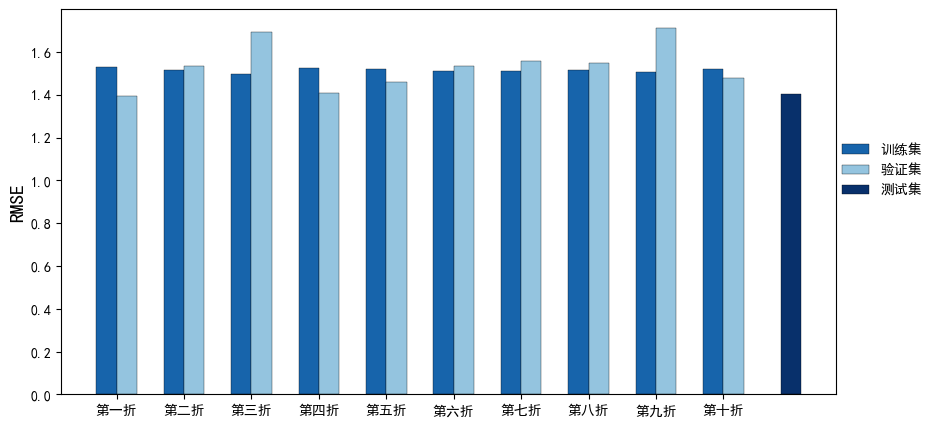

In [11]:
x = np.arange(10)
x_label = ['第一折','第二折','第三折','第四折','第五折','第六折','第七折','第八折','第九折','第十折']
y1 = np.array(train_scores)
y2 = np.array(cv_scores)
fig=plt.figure(figsize=(10, 5))
plt.bar(x-0.15, y1, width=0.3, color=color[1], label='训练集', edgecolor='k', linewidth=0.25)
plt.bar(x+0.15, y2, width=0.3, color=color[3], label='验证集', edgecolor='k', linewidth=0.25)
plt.bar(10, rmse(pred_test_full_lr, test_y), width=0.3, color=color[0], label='测试集', edgecolor='k', linewidth=0.25)
plt.xticks(x, x_label, size=10)
plt.ylabel('RMSE',fontsize=14)
plt.legend(loc=(1, 0.5), ncol=1, frameon=False)
plt.show()

### 决策树

In [12]:
kf = KFold(n_splits=roof_flod, shuffle=True, random_state=42)

pred_train_full_gbr = np.zeros(train_all_x.shape[0])
pred_test_full_gbr = 0
cv_scores = []
train_scores = []

for i, (train_index, val_index) in enumerate(kf.split(train_all_x, train_all_y)):
    print('==> perform fold {}, train size: {}, validate size: {}'.format(i, len(train_index), len(val_index)))
    train_x, val_x = train_all_x.iloc[train_index, :], train_all_x.iloc[val_index, :]
    train_y, val_y = train_all_y[train_index], train_all_y[val_index]
    
    # 创建决策树回归模型
    model = GradientBoostingRegressor()
    model.fit(train_x, train_y)

    # predict train
    predict_train = model.predict(train_x)
    train_rmse = rmse(predict_train, train_y)
    # predict validate
    predict_valid = model.predict(val_x)
    valid_rmse = rmse(predict_valid, val_y)
    # predict test
    predict_test = model.predict(test_x)

    print('train_rmse = {}, valid_rmse = {}'.format(train_rmse, valid_rmse))
    train_scores.append(train_rmse)
    cv_scores.append(valid_rmse)

    # run-out-of-fold predict
    pred_train_full_gbr[val_index] = predict_valid
    pred_test_full_gbr += predict_test

pred_test_full_gbr /= roof_flod
mean_cv_scores = np.mean(cv_scores)
print('Mean train RMSE:', np.mean(train_scores), ', Mean cv RMSE:', np.mean(cv_scores), ', Test RMSE:', rmse(pred_test_full_gbr, test_y))


==> perform fold 0, train size: 3002, validate size: 334
train_rmse = 0.9856580634089398, valid_rmse = 1.0732263612585327
==> perform fold 1, train size: 3002, validate size: 334
train_rmse = 0.9735486734398382, valid_rmse = 1.2036707578382682
==> perform fold 2, train size: 3002, validate size: 334
train_rmse = 0.9583559700974222, valid_rmse = 1.3159854246971752
==> perform fold 3, train size: 3002, validate size: 334
train_rmse = 0.974567223709333, valid_rmse = 1.1153995877655913
==> perform fold 4, train size: 3002, validate size: 334
train_rmse = 0.9965074698164558, valid_rmse = 1.0307880215536174
==> perform fold 5, train size: 3002, validate size: 334
train_rmse = 0.9709068259318959, valid_rmse = 1.2663272638565954
==> perform fold 6, train size: 3003, validate size: 333
train_rmse = 0.9718753320544771, valid_rmse = 1.2699037461930083
==> perform fold 7, train size: 3003, validate size: 333
train_rmse = 0.9696065122652283, valid_rmse = 1.1670126379795418
==> perform fold 8, train

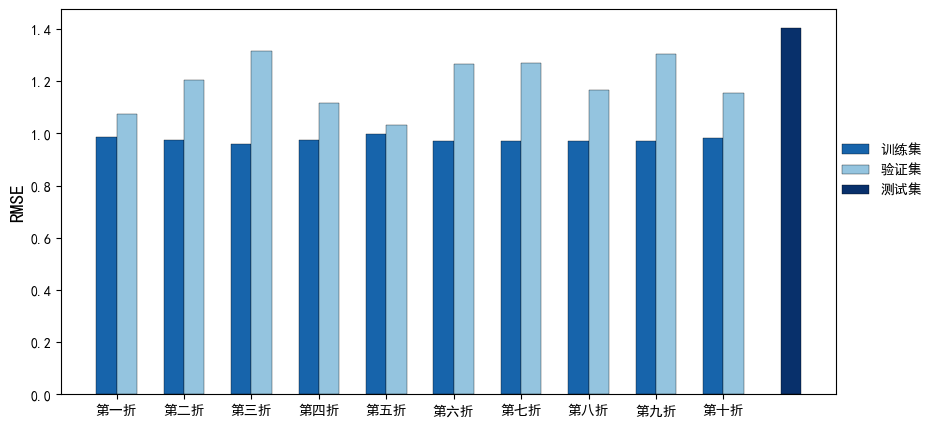

In [13]:
x = np.arange(10)
x_label = ['第一折','第二折','第三折','第四折','第五折','第六折','第七折','第八折','第九折','第十折']
y1 = np.array(train_scores)
y2 = np.array(cv_scores)
fig=plt.figure(figsize=(10, 5))
plt.bar(x-0.15, y1, width=0.3, color=color[1], label='训练集', edgecolor='k', linewidth=0.25)
plt.bar(x+0.15, y2, width=0.3, color=color[3], label='验证集', edgecolor='k', linewidth=0.25)
plt.bar(10, rmse(pred_test_full_lr, test_y), width=0.3, color=color[0], label='测试集', edgecolor='k', linewidth=0.25)
plt.xticks(x, x_label, size=10)
plt.ylabel('RMSE',fontsize=14)
plt.legend(loc=(1, 0.5), ncol=1, frameon=False)
plt.show()

### 随机森林

In [14]:
kf = KFold(n_splits=roof_flod, shuffle=True, random_state=42)

pred_train_full_rf = np.zeros(train_all_x.shape[0])
pred_test_full_rf = 0
cv_scores = []
train_scores = []

for i, (train_index, val_index) in enumerate(kf.split(train_all_x, train_all_y)):
    print('==> perform fold {}, train size: {}, validate size: {}'.format(i, len(train_index), len(val_index)))
    train_x, val_x = train_all_x.iloc[train_index, :], train_all_x.iloc[val_index, :]
    train_y, val_y = train_all_y[train_index], train_all_y[val_index]
    
    # 创建决策树回归模型
    model = RandomForestRegressor()
    model.fit(train_x, train_y)

    # predict train
    predict_train = model.predict(train_x)
    train_rmse = rmse(predict_train, train_y)
    # predict validate
    predict_valid = model.predict(val_x)
    valid_rmse = rmse(predict_valid, val_y)
    # predict test
    predict_test = model.predict(test_x)

    print('train_rmse = {}, valid_rmse = {}'.format(train_rmse, valid_rmse))
    train_scores.append(train_rmse)
    cv_scores.append(valid_rmse)

    # run-out-of-fold predict
    pred_train_full_rf[val_index] = predict_valid
    pred_test_full_rf += predict_test

pred_test_full_rf /= roof_flod
mean_cv_scores = np.mean(cv_scores)
print('Mean train RMSE:', np.mean(train_scores), ', Mean cv RMSE:', np.mean(cv_scores), ', Test RMSE:', rmse(pred_test_full_rf, test_y))


==> perform fold 0, train size: 3002, validate size: 334
train_rmse = 0.44681325784911435, valid_rmse = 1.1112963672197544
==> perform fold 1, train size: 3002, validate size: 334
train_rmse = 0.4437229784517826, valid_rmse = 1.2056413062799278
==> perform fold 2, train size: 3002, validate size: 334
train_rmse = 0.4464789789922483, valid_rmse = 1.2947780447647648
==> perform fold 3, train size: 3002, validate size: 334
train_rmse = 0.4514639975003347, valid_rmse = 1.1034001334477905
==> perform fold 4, train size: 3002, validate size: 334
train_rmse = 0.4569063456004421, valid_rmse = 1.0998710212341358
==> perform fold 5, train size: 3002, validate size: 334
train_rmse = 0.44558476550583725, valid_rmse = 1.2469941271091893
==> perform fold 6, train size: 3003, validate size: 333
train_rmse = 0.44363243784009043, valid_rmse = 1.316779559589053
==> perform fold 7, train size: 3003, validate size: 333
train_rmse = 0.4464087125650691, valid_rmse = 1.1600403990298285
==> perform fold 8, tr

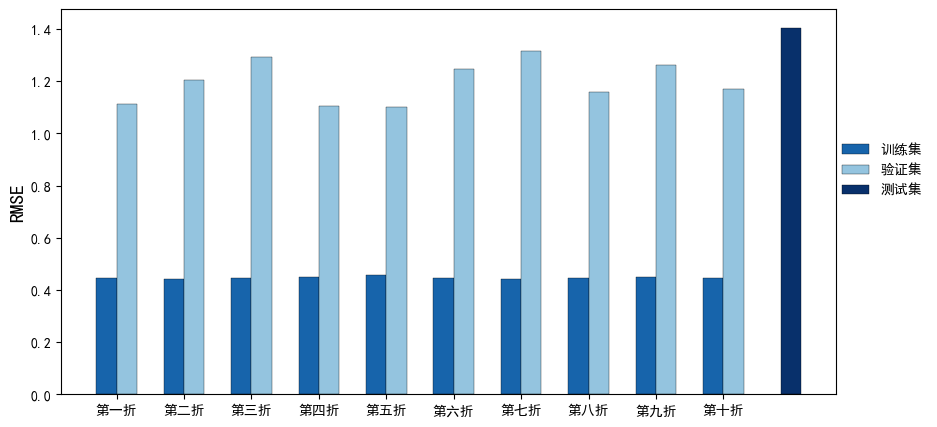

In [15]:
x = np.arange(10)
x_label = ['第一折','第二折','第三折','第四折','第五折','第六折','第七折','第八折','第九折','第十折']
y1 = np.array(train_scores)
y2 = np.array(cv_scores)
fig=plt.figure(figsize=(10, 5))
plt.bar(x-0.15, y1, width=0.3, color=color[1], label='训练集', edgecolor='k', linewidth=0.25)
plt.bar(x+0.15, y2, width=0.3, color=color[3], label='验证集', edgecolor='k', linewidth=0.25)
plt.bar(10, rmse(pred_test_full_lr, test_y), width=0.3, color=color[0], label='测试集', edgecolor='k', linewidth=0.25)
plt.xticks(x, x_label, size=10)
plt.ylabel('RMSE',fontsize=14)
plt.legend(loc=(1, 0.5), ncol=1, frameon=False)
plt.show()

## 模型预测效果总结

In [16]:
# 维度变换
pred_train_full_lr = np.reshape(pred_train_full_lr, (pred_train_full_lr.shape[0], 1))
pred_train_full_ridge = np.reshape(pred_train_full_ridge, (pred_train_full_ridge.shape[0], 1))
pred_train_full_lasso = np.reshape(pred_train_full_lasso, (pred_train_full_lasso.shape[0], 1))
pred_train_full_gbr = np.reshape(pred_train_full_gbr, (pred_train_full_gbr.shape[0], 1))
pred_train_full_rf = np.reshape(pred_train_full_rf, (pred_train_full_rf.shape[0], 1))

pred_test_full_lr = np.reshape(pred_test_full_lr, (pred_test_full_lr.shape[0], 1))
pred_test_full_ridge = np.reshape(pred_test_full_ridge, (pred_test_full_ridge.shape[0], 1))
pred_test_full_lasso = np.reshape(pred_test_full_lasso, (pred_test_full_lasso.shape[0], 1))
pred_test_full_gbr = np.reshape(pred_test_full_gbr, (pred_test_full_gbr.shape[0], 1))
pred_test_full_rf = np.reshape(pred_test_full_rf, (pred_test_full_rf.shape[0], 1))

In [17]:
# 交叉方式预测的结果进行拼接
oof_train_x = np.concatenate([pred_train_full_lr, pred_train_full_ridge,
                              pred_train_full_lasso, pred_train_full_gbr, pred_train_full_rf], axis=1)

oof_test_x = np.concatenate([pred_test_full_lr, pred_test_full_ridge,
                             pred_test_full_lasso, pred_test_full_gbr, pred_test_full_rf], axis=1)

In [18]:
cmap=cm.get_cmap('Blues_r',6)
color=[colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)] 

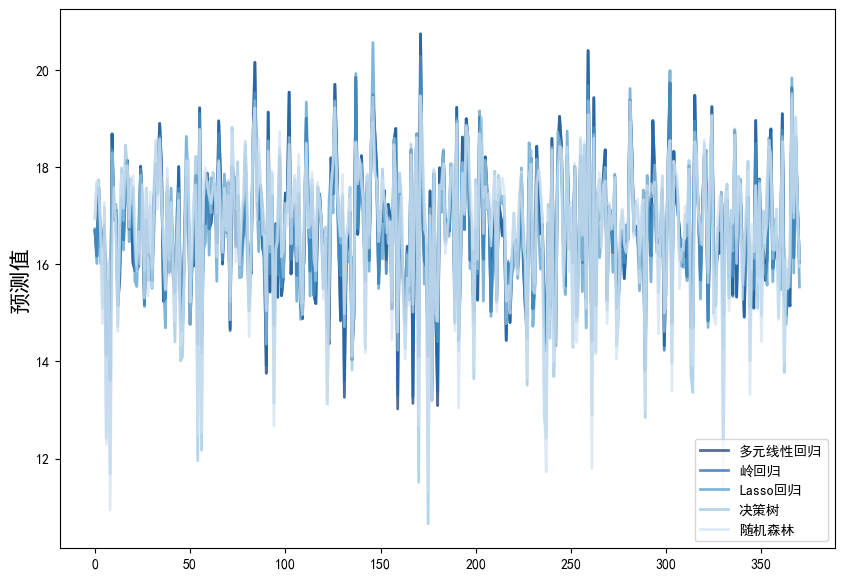

In [19]:
plt.figure(figsize=(10, 7))
plt.plot(pred_test_full_lr, c=color[0], linewidth=2, label='多元线性回归',alpha=0.7)
plt.plot(pred_test_full_ridge, c=color[1], linewidth=2, label='岭回归',alpha=0.7)
plt.plot(pred_test_full_lasso, c=color[2], linewidth=2, label='Lasso回归',alpha=0.7)
plt.plot(pred_test_full_gbr, c=color[3], linewidth=2, label='决策树',alpha=0.7)
plt.plot(pred_test_full_rf, c=color[4], linewidth=2, label='随机森林',alpha=0.7)
plt.ylabel('预测值',fontsize=16)
plt.legend()
plt.show()